# Sustainability Analytics Project
## 1. Weather Date from openmeteo

In [23]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": 47.39,
	"longitude": 8.05,
	"start_date": "2020-01-01",
	"end_date": "2024-12-31",
	"daily": ["wind_speed_10m_mean", "temperature_2m_mean", "cloud_cover_mean"],
	"hourly": ["wind_speed_10m", "global_tilted_irradiance", "temperature_2m", "relative_humidity_2m"],
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_wind_speed_10m = hourly.Variables(0).ValuesAsNumpy()
hourly_global_tilted_irradiance = hourly.Variables(1).ValuesAsNumpy()
hourly_temperature_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["global_tilted_irradiance"] = hourly_global_tilted_irradiance
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_wind_speed_10m_mean = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(1).ValuesAsNumpy()
daily_cloud_cover_mean = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["wind_speed_10m_mean"] = daily_wind_speed_10m_mean
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["cloud_cover_mean"] = daily_cloud_cover_mean

daily_dataframe = pd.DataFrame(data = daily_data)
print("\nDaily data\n", daily_dataframe)

OpenMeteoRequestsError: failed to request 'https://historical-forecast-api.open-meteo.com/v1/forecast': Unexpected error while streaming data: timeoutReached

In [2]:
# --- Aggregate hourly -> daily (UTC days) ---

# Ensure timezone-aware UTC and add "day" column normalized to midnight UTC
hourly_df = hourly_dataframe.copy()
hourly_df["date"] = pd.to_datetime(hourly_df["date"], utc=True)
hourly_df["day"] = hourly_df["date"].dt.normalize()  # midnight UTC

# Choose aggregations:
# - Means for wind/temp/RH
# - Sum for irradiance (approx daily energy proxy if hourly means of W/m²)
agg_spec = {
    "wind_speed_10m": "mean",
    "temperature_2m": "mean",
    "relative_humidity_2m": "mean",
    "global_tilted_irradiance": "sum",
}

hourly_to_daily = (
    hourly_df.groupby("day", as_index=False)
             .agg(agg_spec)
             .rename(columns={
                 "day": "date",
                 "wind_speed_10m": "wind_speed_10m_mean_from_hourly",
                 "temperature_2m": "temperature_2m_mean_from_hourly",
                 "relative_humidity_2m": "relative_humidity_2m_mean_from_hourly",
                 "global_tilted_irradiance": "global_tilted_irradiance_sum_Wh_m2"
             })
)

# Optional: convert the irradiance daily sum from Wh/m² to MJ/m²
hourly_to_daily["global_tilted_irradiance_sum_MJ_m2"] = (
    hourly_to_daily["global_tilted_irradiance_sum_Wh_m2"] * 3600 / 1e6
)

print("\nHourly aggregated to daily\n", hourly_to_daily)

# --- Combine with API-provided daily data ---

# Ensure daily_dataframe 'date' is UTC-normalized (it already is, but to be safe)
daily_df = daily_dataframe.copy()
daily_df["date"] = pd.to_datetime(daily_df["date"], utc=True).dt.normalize()

# Outer join to keep any days that exist in one set but not the other.
combined_daily = (
    daily_df.merge(hourly_to_daily, on="date", how="outer")
            .sort_values("date")
            .reset_index(drop=True)
)

print("\nCombined daily (API daily + aggregated hourly)\n", combined_daily)


Hourly aggregated to daily
                          date  wind_speed_10m_mean_from_hourly  \
0   2023-09-01 00:00:00+00:00                         5.628584   
1   2023-09-02 00:00:00+00:00                         3.370706   
2   2023-09-03 00:00:00+00:00                         5.400915   
3   2023-09-04 00:00:00+00:00                         7.875790   
4   2023-09-05 00:00:00+00:00                         5.432749   
..                        ...                              ...   
664 2025-06-26 00:00:00+00:00                         6.114120   
665 2025-06-27 00:00:00+00:00                         5.134716   
666 2025-06-28 00:00:00+00:00                         3.202209   
667 2025-06-29 00:00:00+00:00                         4.454076   
668 2025-06-30 00:00:00+00:00                         4.968901   

     temperature_2m_mean_from_hourly  relative_humidity_2m_mean_from_hourly  \
0                          18.508583                              77.041664   
1                   

### synthetic-dataset-aargauer-energie-werke_2020-2025.csv

In [6]:
# Load city data
df_energie = pd.read_csv("../data/synthetic-dataset-aargauer-energie-werke_2020-2025.csv")
# Show the first few rows
print(df_energie.head())


  com_fosnr            Address        Date  PV_Production_kWh  \
0      4001  Kasernenstrasse 1  2023-09-01               23.5   
1      4001  Kasernenstrasse 1  2023-09-02               19.9   
2      4001  Kasernenstrasse 1  2023-09-03               18.2   
3      4001  Kasernenstrasse 1  2023-09-04               22.8   
4      4001  Kasernenstrasse 1  2023-09-05               25.1   

   Consumption_Base_Load_kWh  Consumption_Heat_Pump_kWh  \
0                        3.9                        1.1   
1                        3.7                        1.4   
2                        3.8                        1.9   
3                        3.9                        0.9   
4                        3.6                        0.5   

   Consumption_EV_Charging_kWh  Consumption_Cooking_Lighting_etc_kWh  \
0                         10.5                                   4.3   
1                         10.2                                   4.5   
2                          0.0        

In [7]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\xwxba\Documents\DataSc\Sustainability-Analytics\code


In [8]:
import pandas as pd

# --- Pick the daily weather table you have ---
# If you built hourly→daily + merged, use that; otherwise fall back to API daily.
weather_daily = (combined_daily if 'combined_daily' in locals() else daily_dataframe).copy()

# Keep just the date + desired weather columns (add/remove as needed)
keep_cols = [
    "date",
    "wind_speed_10m_mean",
    "temperature_2m_mean",
    "cloud_cover_mean",
    # If you created these from hourly aggregation, include them too:
    "wind_speed_10m_mean_from_hourly",
    "temperature_2m_mean_from_hourly",
    "relative_humidity_2m_mean_from_hourly",
    "global_tilted_irradiance_sum_Wh_m2",
    "global_tilted_irradiance_sum_MJ_m2",
]
weather_daily = weather_daily[[c for c in keep_cols if c in weather_daily.columns]].copy()

# --- Normalize dates to the same timezone/day definition ---
# If your energy data uses local Swiss calendar days, set tz to Europe/Zurich.
USE_LOCAL_TZ = None  # set to "Europe/Zurich" if your energy 'Date' is local days

if USE_LOCAL_TZ:
    # Align both sides to local days, then normalize
    weather_daily["date"] = (
        pd.to_datetime(weather_daily["date"], utc=True)
          .dt.tz_convert(USE_LOCAL_TZ)
          .dt.normalize()
    )
    df_energie["Date"] = (
        pd.to_datetime(df_energie["Date"])
          .dt.tz_localize(USE_LOCAL_TZ)  # dates without time become local midnight
          .dt.normalize()
    )
else:
    # Treat both as UTC-based days
    weather_daily["date"] = pd.to_datetime(weather_daily["date"], utc=True).dt.normalize()
    df_energie["Date"] = pd.to_datetime(df_energie["Date"], utc=True).dt.normalize()

# --- Merge: add weather columns onto energy rows by date ---
df_energie_with_weather = df_energie.merge(
    weather_daily.rename(columns={"date": "Date"}),
    on="Date",
    how="left"
)

print(df_energie_with_weather.head())
print(df_energie_with_weather.filter(regex="Date|PV_|Consumption_|wind|temp|cloud|irradiance").head())


  com_fosnr            Address                      Date  PV_Production_kWh  \
0      4001  Kasernenstrasse 1 2023-09-01 00:00:00+00:00               23.5   
1      4001  Kasernenstrasse 1 2023-09-02 00:00:00+00:00               19.9   
2      4001  Kasernenstrasse 1 2023-09-03 00:00:00+00:00               18.2   
3      4001  Kasernenstrasse 1 2023-09-04 00:00:00+00:00               22.8   
4      4001  Kasernenstrasse 1 2023-09-05 00:00:00+00:00               25.1   

   Consumption_Base_Load_kWh  Consumption_Heat_Pump_kWh  \
0                        3.9                        1.1   
1                        3.7                        1.4   
2                        3.8                        1.9   
3                        3.9                        0.9   
4                        3.6                        0.5   

   Consumption_EV_Charging_kWh  Consumption_Cooking_Lighting_etc_kWh  \
0                         10.5                                   4.3   
1                         

In [10]:
# Count missing values per column
na_counts = df_energie_with_weather.isna().sum()

print("Missing values per column:\n", na_counts)

# Optionally: show only columns with NA values
print("\nColumns with NA values:\n", na_counts[na_counts > 0])

# Quick summary: total NAs in dataset
print("\nTotal NA values:", df_energie_with_weather.isna().sum().sum())

Missing values per column:
 com_fosnr                                0
Address                                  0
Date                                     0
PV_Production_kWh                        0
Consumption_Base_Load_kWh                0
Consumption_Heat_Pump_kWh                0
Consumption_EV_Charging_kWh              0
Consumption_Cooking_Lighting_etc_kWh     0
Consumption_Total_kWh                    0
Self_Consumption_PV_kWh                  0
Grid_Feed_In_PV_kWh                      0
Grid_Import_Total_kWh                    0
wind_speed_10m_mean                      0
temperature_2m_mean                      0
cloud_cover_mean                         0
wind_speed_10m_mean_from_hourly          0
temperature_2m_mean_from_hourly          0
relative_humidity_2m_mean_from_hourly    0
global_tilted_irradiance_sum_Wh_m2       0
global_tilted_irradiance_sum_MJ_m2       0
dtype: int64

Columns with NA values:
 Series([], dtype: int64)

Total NA values: 0


In [11]:
# Save to CSV
df_energie_with_weather.to_csv("../data/df_energie_weather.csv", index=False)

print("File saved as df_energie_weather.csv")

File saved as df_energie_weather.csv


### household_energy_profile_Wynemattestrasse_17_5_years.csv

In [13]:
# Load 5year data
df_energie_5year = pd.read_csv("../data/household_energy_profile_Wynemattestrasse_17_5_years.csv")
# Show the first few rows
print(df_energie_5year.head())

# Show the shape (rows, columns)
print(df_energie_5year.shape)

# Show column names and dtypes
print(df_energie_5year.info())

# Quick statistics for numeric columns
print(df_energie_5year.describe())


   com_fosnr              Address   Timestamp  \
0       4001  Wynemattestrasse 17  2020-01-01   
1       4001  Wynemattestrasse 17  2020-01-01   
2       4001  Wynemattestrasse 17  2020-01-01   
3       4001  Wynemattestrasse 17  2020-01-01   
4       4001  Wynemattestrasse 17  2020-01-01   

                                 Metric   Value  
0                     PV_Production_kWh  0.0000  
1             Consumption_Base_Load_kWh  0.2320  
2             Consumption_Heat_Pump_kWh  0.9809  
3           Consumption_EV_Charging_kWh  0.0000  
4  Consumption_Cooking_Lighting_etc_kWh  0.1018  
(438480, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438480 entries, 0 to 438479
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   com_fosnr  438480 non-null  int64  
 1   Address    438480 non-null  object 
 2   Timestamp  438480 non-null  object 
 3   Metric     438480 non-null  object 
 4   Value      438480 non-null  floa

In [14]:
# Pivot from long → wide
df_energie_5year_wide = df_energie_5year.pivot_table(
    index=["com_fosnr", "Address", "Timestamp"],  # keep these as row identifiers
    columns="Metric",                             # make each metric a column
    values="Value"                                # values go inside cells
).reset_index()

# Flatten MultiIndex columns if needed
df_energie_5year_wide.columns.name = None

print(df_energie_5year_wide.head())
print(df_energie_5year_wide.shape)

   com_fosnr              Address            Timestamp  \
0       4001  Wynemattestrasse 17           2020-01-01   
1       4001  Wynemattestrasse 17  2020-01-01 01:00:00   
2       4001  Wynemattestrasse 17  2020-01-01 02:00:00   
3       4001  Wynemattestrasse 17  2020-01-01 03:00:00   
4       4001  Wynemattestrasse 17  2020-01-01 04:00:00   

   Consumption_Base_Load_kWh  Consumption_Cooking_Lighting_etc_kWh  \
0                      0.232                                0.1018   
1                      0.188                                0.1424   
2                      0.155                                0.2164   
3                      0.151                                0.0855   
4                      0.112                                0.3167   

   Consumption_EV_Charging_kWh  Consumption_Heat_Pump_kWh  \
0                          0.0                     0.9809   
1                          0.0                     1.0262   
2                          0.0                 

In [64]:
import pandas as pd

# Ensure Timestamp is datetime
df_energie_5year["Timestamp"] = pd.to_datetime(df_energie_5year["Timestamp"])

# Count number of records per day
records_per_day = df_energie_5year.groupby(df_energie_5year["Timestamp"].dt.date).size()

# Find days with fewer or more than 24 records
incomplete_days = records_per_day[records_per_day != 24]

print("Total days:", len(records_per_day))
print("Complete days (24 records):", (records_per_day == 24).sum())
print("Incomplete days:", len(incomplete_days))
print("\nExamples of incomplete days:")
print(incomplete_days.head())


Total days: 1827
Complete days (24 records): 0
Incomplete days: 1827

Examples of incomplete days:
Timestamp
2020-01-01    10
2020-01-02    10
2020-01-03    10
2020-01-04    10
2020-01-05    10
dtype: int64


In [15]:
# Show unique metric names
print(df_energie_5year["Metric"].unique())

# Or number of unique metrics
print("Number of distinct metrics:", df_energie_5year["Metric"].nunique())

# If you want counts per metric
print(df_energie_5year["Metric"].value_counts())


['PV_Production_kWh' 'Consumption_Base_Load_kWh'
 'Consumption_Heat_Pump_kWh' 'Consumption_EV_Charging_kWh'
 'Consumption_Cooking_Lighting_etc_kWh' 'Grid_Feed_In_PV_kWh'
 'Grid_Import_Total_kWh' 'Self_Consumption_PV_kWh' 'is_grid_disturbance'
 'is_price_spike_response']
Number of distinct metrics: 10
Metric
PV_Production_kWh                       43848
Consumption_Base_Load_kWh               43848
Consumption_Heat_Pump_kWh               43848
Consumption_EV_Charging_kWh             43848
Consumption_Cooking_Lighting_etc_kWh    43848
Grid_Feed_In_PV_kWh                     43848
Grid_Import_Total_kWh                   43848
Self_Consumption_PV_kWh                 43848
is_grid_disturbance                     43848
is_price_spike_response                 43848
Name: count, dtype: int64


In [16]:
# Count missing values per column
na_counts = df_energie_5year_wide.isna().sum()

print("Missing values per column:\n", na_counts)

Missing values per column:
 com_fosnr                               0
Address                                 0
Timestamp                               0
Consumption_Base_Load_kWh               0
Consumption_Cooking_Lighting_etc_kWh    0
Consumption_EV_Charging_kWh             0
Consumption_Heat_Pump_kWh               0
Grid_Feed_In_PV_kWh                     0
Grid_Import_Total_kWh                   0
PV_Production_kWh                       0
Self_Consumption_PV_kWh                 0
is_grid_disturbance                     0
is_price_spike_response                 0
dtype: int64


In [38]:
# Convert to datetime, invalid parsing becomes NaT
df_energie_5year["Timestamp"] = pd.to_datetime(df_energie_5year["Timestamp"], errors="coerce")

# Extract only the calendar date (dtype will be 'object' with datetime.date values)
df_energie_5year["Date"] = df_energie_5year["Timestamp"].dt.date

# Drop rows where conversion failed (optional, but avoids float/NaN mixing)
df_energie_5year = df_energie_5year.dropna(subset=["Date"])

# Now check start and end
start_date = df_energie_5year["Date"].min()
end_date = df_energie_5year["Date"].max()

print("Start date:", start_date)
print("End date:", end_date)



Start date: 2020-01-01
End date: 2024-12-31


### Add MeteoSwiss weather date

In [39]:
# upload historical weather data from MeteoSwiss
df_ogd = pd.read_csv("../data/ogd-nbcn_sma_d_historical.csv", 
                     encoding="latin1", 
                     sep=";")

df_ogd_meta_parameters = pd.read_csv("../data/ogd-nbcn_meta_parameters.csv", 
                                     encoding="latin1", 
                                     sep=";")

# Show the first few rows
print(df_ogd.head())
print(df_ogd_meta_parameters.head())
print(df_ogd_meta_parameters.info())
print(df_ogd.info())

  station_abbr reference_timestamp  ths200dn  ths200dx  ths200d0  th9120dv  \
0          SMA    01.01.1864 00:00       NaN       NaN      -1.6      -2.6   
1          SMA    02.01.1864 00:00       NaN       NaN      -8.8      -9.8   
2          SMA    03.01.1864 00:00       NaN       NaN     -12.0     -13.0   
3          SMA    04.01.1864 00:00       NaN       NaN     -11.1     -12.1   
4          SMA    05.01.1864 00:00       NaN       NaN     -12.2     -13.1   

   th91dndv  th91dxdv  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN  
  parameter_shortname                           parameter_description_de  \
0            fh9120mv  Windgeschwindigkeit skalar; Verhältnis des hom...   
1            fh9120yv  Windgeschwindigkeit skalar; Verhältnis des hom...   
2            fhs010m0  Windgeschwindigkeit skalar; homogenes Monatsmi...   
3            fhs010y0  Windgeschwindigkeit skalar; homogenes Jahresmi...   
4      

In [40]:
import pandas as pd

# Keep only station, date and the daily mean temperature
df_temp = df_ogd[["station_abbr", "reference_timestamp", "th9120dv"]].copy()

# Rename column
df_temp = df_temp.rename(columns={"th9120dv": "daily_temperature"})

# Convert timestamp to datetime
df_temp["reference_timestamp"] = pd.to_datetime(df_temp["reference_timestamp"], format="%d.%m.%Y %H:%M")

# Filter date range
mask = (df_temp["reference_timestamp"] >= "2020-01-01") & (df_temp["reference_timestamp"] <= "2025-08-01")
df_temp = df_temp.loc[mask]

print(df_temp.head())
print(df_temp.tail())




      station_abbr reference_timestamp  daily_temperature
56978          SMA          2020-01-01               -2.9
56979          SMA          2020-01-02               -2.2
56980          SMA          2020-01-03                2.0
56981          SMA          2020-01-04                3.9
56982          SMA          2020-01-05                0.7
      station_abbr reference_timestamp  daily_temperature
58800          SMA          2024-12-27               -2.9
58801          SMA          2024-12-28               -2.6
58802          SMA          2024-12-29               -2.8
58803          SMA          2024-12-30               -3.3
58804          SMA          2024-12-31               -3.5


In [43]:
# upload historical weather data from MeteoSwiss
df_ogd_smn = pd.read_csv("../data/ogd-smn_bus_d_historical.csv", 
                     encoding="latin1", 
                     sep=";")

df_ogd_smn_meta_parameters = pd.read_csv("../data/ogd-smn_meta_parameters.csv", 
                                     encoding="latin1", 
                                     sep=";")

# Show the first few rows
print(df_ogd_smn.head())
print(df_ogd_smn_meta_parameters.head())
print(df_ogd_smn_meta_parameters.info())
print(df_ogd_smn.info())

  station_abbr reference_timestamp  tre200d0  tre200dx  tre200dn  tre005d0  \
0          BUS    22.05.1984 00:00       NaN      17.0       9.4       NaN   
1          BUS    23.05.1984 00:00      10.5      21.1       8.1      10.7   
2          BUS    24.05.1984 00:00      11.7      16.8       7.1      11.7   
3          BUS    25.05.1984 00:00      10.1      12.1       9.0       9.8   
4          BUS    26.05.1984 00:00      12.3      18.6       8.4      12.8   

   tre005dx  tre005dn  ure200d0  pva200d0  ...  osr000d0  ods000d0  sre000d0  \
0      18.2       8.8       NaN       NaN  ...       NaN       NaN       NaN   
1      15.8       7.4      86.0      11.0  ...       NaN       NaN      63.0   
2      18.1       6.2      74.1       9.9  ...       NaN       NaN     216.0   
3      11.9       8.5      91.3      11.3  ...       NaN       NaN       0.0   
4      20.3       7.8      81.0      11.3  ...       NaN       NaN     169.0   

   sremaxdv  erefaod0  xcd000d0  dkl010d0  xno000d

In [44]:
import pandas as pd

# Get the list of parameter columns (skip station and timestamp)
param_columns = [col for col in df_ogd_smn.columns if col not in ["station_abbr", "reference_timestamp"]]

# Build a mapping from metadata
meta_map = df_ogd_smn_meta_parameters.set_index("parameter_shortname")[[
    "parameter_description_de", "parameter_description_en", "parameter_unit"
]]

# Create new dataframe with column + interpretation
df_parameters = pd.DataFrame({"parameter_shortname": param_columns})
df_parameters = df_parameters.join(meta_map, on="parameter_shortname")

# Optional: combine into a readable interpretation column
df_parameters["interpretation"] = (
    df_parameters["parameter_description_en"].fillna(df_parameters["parameter_description_de"])
    + " [" + df_parameters["parameter_unit"].astype(str) + "]"
)

print(df_parameters.head(20))


   parameter_shortname                           parameter_description_de  \
0             tre200d0         Lufttemperatur 2 m über Boden; Tagesmittel   
1             tre200dx        Lufttemperatur 2 m über Boden; Tagesmaximum   
2             tre200dn        Lufttemperatur 2 m über Boden; Tagesminimum   
3             tre005d0         Lufttemperatur 5 cm über Gras; Tagesmittel   
4             tre005dx        Lufttemperatur 5 cm über Gras; Tagesmaximum   
5             tre005dn        Lufttemperatur 5 cm über Gras; Tagesminimum   
6             ure200d0  Relative Luftfeuchtigkeit 2 m über Boden; Tage...   
7             pva200d0             Dampfdruck 2 m über Boden; Tagesmittel   
8             prestad0     Luftdruck auf Barometerhöhe (QFE); Tagesmittel   
9             pp0qffd0  Luftdruck reduziert auf Meeresniveau (QFF); Ta...   
10            ppz850d0  Geopotentielle Höhe der 850 hPa-Fläche; Tagesm...   
11            ppz700d0  Geopotentielle Höhe der 700 hPa-Fläche; Tagesm...   

In [48]:
# Keep only selected columns
df_weather = df_ogd_smn[[
    "station_abbr", 
    "reference_timestamp", 
    "tre200d0",   # daily temperature
    "ure200d0",   # humidity
    "fkl010d0"    # wind speed
]].copy()

# Rename them
df_weather = df_weather.rename(columns={
    "tre200d0": "temperature_daily/°C",
    "ure200d0": "humidity/%",
    "fkl010d0": "wind_speed/m/s"
})

# Convert timestamp to datetime
df_weather["reference_timestamp"] = pd.to_datetime(
    df_weather["reference_timestamp"], format="%d.%m.%Y %H:%M"
)

# Create a date-only column
df_weather["date"] = df_weather["reference_timestamp"].dt.date

# Filter rows with date > 2020-01-01
df_weather = df_weather[df_weather["reference_timestamp"] > "2020-01-01"]

print(df_weather.head())
print(df_weather.tail())
print(df_weather["reference_timestamp"].min(), df_weather["reference_timestamp"].max())


      station_abbr reference_timestamp  temperature_daily/°C  humidity/%  \
13008          BUS          2020-01-02                  -0.2        91.4   
13009          BUS          2020-01-03                   3.4        91.8   
13010          BUS          2020-01-04                   5.0        83.0   
13011          BUS          2020-01-05                   1.0        87.0   
13012          BUS          2020-01-06                   0.3        91.4   

       wind_speed/m/s        date  
13008             1.8  2020-01-02  
13009             1.2  2020-01-03  
13010             1.4  2020-01-04  
13011             0.7  2020-01-05  
13012             1.3  2020-01-06  
      station_abbr reference_timestamp  temperature_daily/°C  humidity/%  \
14829          BUS          2024-12-27                  -1.3        90.7   
14830          BUS          2024-12-28                  -0.9        93.6   
14831          BUS          2024-12-29                  -1.0        93.8   
14832          BUS     

In [49]:
# Count missing values per column
na_counts = df_weather.isna().sum()

print("Missing values per column:\n", na_counts)

Missing values per column:
 station_abbr            0
reference_timestamp     0
temperature_daily/°C    0
humidity/%              0
wind_speed/m/s          0
date                    0
dtype: int64


In [68]:
import pandas as pd

# ensure Timestamp is datetime
df_energie_5year_wide["Timestamp"] = pd.to_datetime(df_energie_5year_wide["Timestamp"])

# add a date-only column (python date objects)
df_energie_5year_wide["date"] = df_energie_5year_wide["Timestamp"].dt.date


In [69]:
# Convert and align column names
df_energie_5year_wide["date"] = pd.to_datetime(df_energie_5year["date"]).dt.date
df_weather["date"] = pd.to_datetime(df_weather["reference_timestamp"]).dt.date

# Merge on date
df_merged = pd.merge(df_energie_5year_wide, df_weather, on="date", how="inner")

# Drop duplicate timestamp column from weather
df_merged = df_merged.drop(columns=["reference_timestamp"])

print(df_merged.head())
print(df_merged.info())


   com_fosnr              Address  Timestamp  Consumption_Base_Load_kWh  \
0       4001  Wynemattestrasse 17 2020-01-11                      0.068   
1       4001  Wynemattestrasse 17        NaT                      0.176   
2       4001  Wynemattestrasse 17        NaT                      0.079   
3       4001  Wynemattestrasse 17        NaT                      0.150   
4       4001  Wynemattestrasse 17        NaT                      0.192   

   Consumption_Cooking_Lighting_etc_kWh  Consumption_EV_Charging_kWh  \
0                                0.0820                          0.0   
1                                0.0576                          0.0   
2                                0.1114                          0.0   
3                                0.0869                          0.0   
4                                0.0881                          0.0   

   Consumption_Heat_Pump_kWh  Grid_Feed_In_PV_kWh  Grid_Import_Total_kWh  \
0                     0.9319            

In [70]:
# Count missing values per column
na_counts = df_merged.isna().sum()

print("Missing values per column:\n", na_counts)


Missing values per column:
 com_fosnr                                  0
Address                                    0
Timestamp                               1718
Consumption_Base_Load_kWh                  0
Consumption_Cooking_Lighting_etc_kWh       0
Consumption_EV_Charging_kWh                0
Consumption_Heat_Pump_kWh                  0
Grid_Feed_In_PV_kWh                        0
Grid_Import_Total_kWh                      0
PV_Production_kWh                          0
Self_Consumption_PV_kWh                    0
is_grid_disturbance                        0
is_price_spike_response                    0
date                                       0
station_abbr                               0
temperature_daily/°C                       0
humidity/%                                 0
wind_speed/m/s                             0
dtype: int64


In [71]:
# Basic info about the Timestamp column
print("Column dtype:", df_energie_5year_wide["Timestamp"].dtype)
print("Non-null values:", df_energie_5year_wide["Timestamp"].notna().sum())
print("Missing values:", df_energie_5year_wide["Timestamp"].isna().sum())
print("Min timestamp:", df_energie_5year_wide["Timestamp"].min())
print("Max timestamp:", df_energie_5year_wide["Timestamp"].max())

# Show first few rows
print("\nFirst 10 timestamps:")
print(df_energie_5year_wide["Timestamp"].head(10))

# Show last few rows
print("\nLast 10 timestamps:")
print(df_energie_5year_wide["Timestamp"].tail(10))


Column dtype: datetime64[ns]
Non-null values: 1827
Missing values: 42016
Min timestamp: 2020-01-01 00:00:00
Max timestamp: 2024-12-31 00:00:00

First 10 timestamps:
0   2020-01-01
1          NaT
2          NaT
3          NaT
4          NaT
5          NaT
6          NaT
7          NaT
8          NaT
9          NaT
Name: Timestamp, dtype: datetime64[ns]

Last 10 timestamps:
43833   NaT
43834   NaT
43835   NaT
43836   NaT
43837   NaT
43838   NaT
43839   NaT
43840   NaT
43841   NaT
43842   NaT
Name: Timestamp, dtype: datetime64[ns]


In [76]:
# 1. Convert Timestamp to datetime
df_energie_5year_wide["Timestamp"] = pd.to_datetime(df_energie_5year_wide["Timestamp"], errors="coerce")

# 2. Keep only rows where time == 00:00:00
df_energie_5year_wide = df_energie_5year_wide[
    df_energie_5year_wide["Timestamp"].dt.time == pd.to_datetime("00:00:00").time()
].copy()

# 3. Replace Timestamp with only the date part
df_energie_5year_wide["date"] = df_energie_5year_wide["Timestamp"].dt.date

# 4. Prepare weather dataframe
df_weather["reference_timestamp"] = pd.to_datetime(df_weather["reference_timestamp"], format="%d.%m.%Y %H:%M")
df_weather["date"] = df_weather["reference_timestamp"].dt.date

# 5. Merge on date
df_merged = pd.merge(df_energie_5year_wide, df_weather, on="date", how="inner")

# 6. Drop duplicate timestamp from weather
df_merged = df_merged.drop(columns=["reference_timestamp"])
df_merged = df_merged.drop(columns=["date"])
print(df_merged.head())
print(df_merged.info())


   com_fosnr              Address  Timestamp  Consumption_Base_Load_kWh  \
0       4001  Wynemattestrasse 17 2020-01-02                      0.087   
1       4001  Wynemattestrasse 17 2020-01-03                      0.144   
2       4001  Wynemattestrasse 17 2020-01-04                      0.256   
3       4001  Wynemattestrasse 17 2020-01-05                      0.097   
4       4001  Wynemattestrasse 17 2020-01-06                      0.134   

   Consumption_Cooking_Lighting_etc_kWh  Consumption_EV_Charging_kWh  \
0                                0.1994                          0.0   
1                                0.0838                          0.0   
2                                0.1629                          0.0   
3                                0.2266                          0.0   
4                                0.2202                          0.0   

   Consumption_Heat_Pump_kWh  Grid_Feed_In_PV_kWh  Grid_Import_Total_kWh  \
0                     1.2086            

In [77]:
# Save merged dataframe to CSV
df_merged.to_csv("../data/df_5year_weater_merged.csv", index=False, encoding="utf-8")


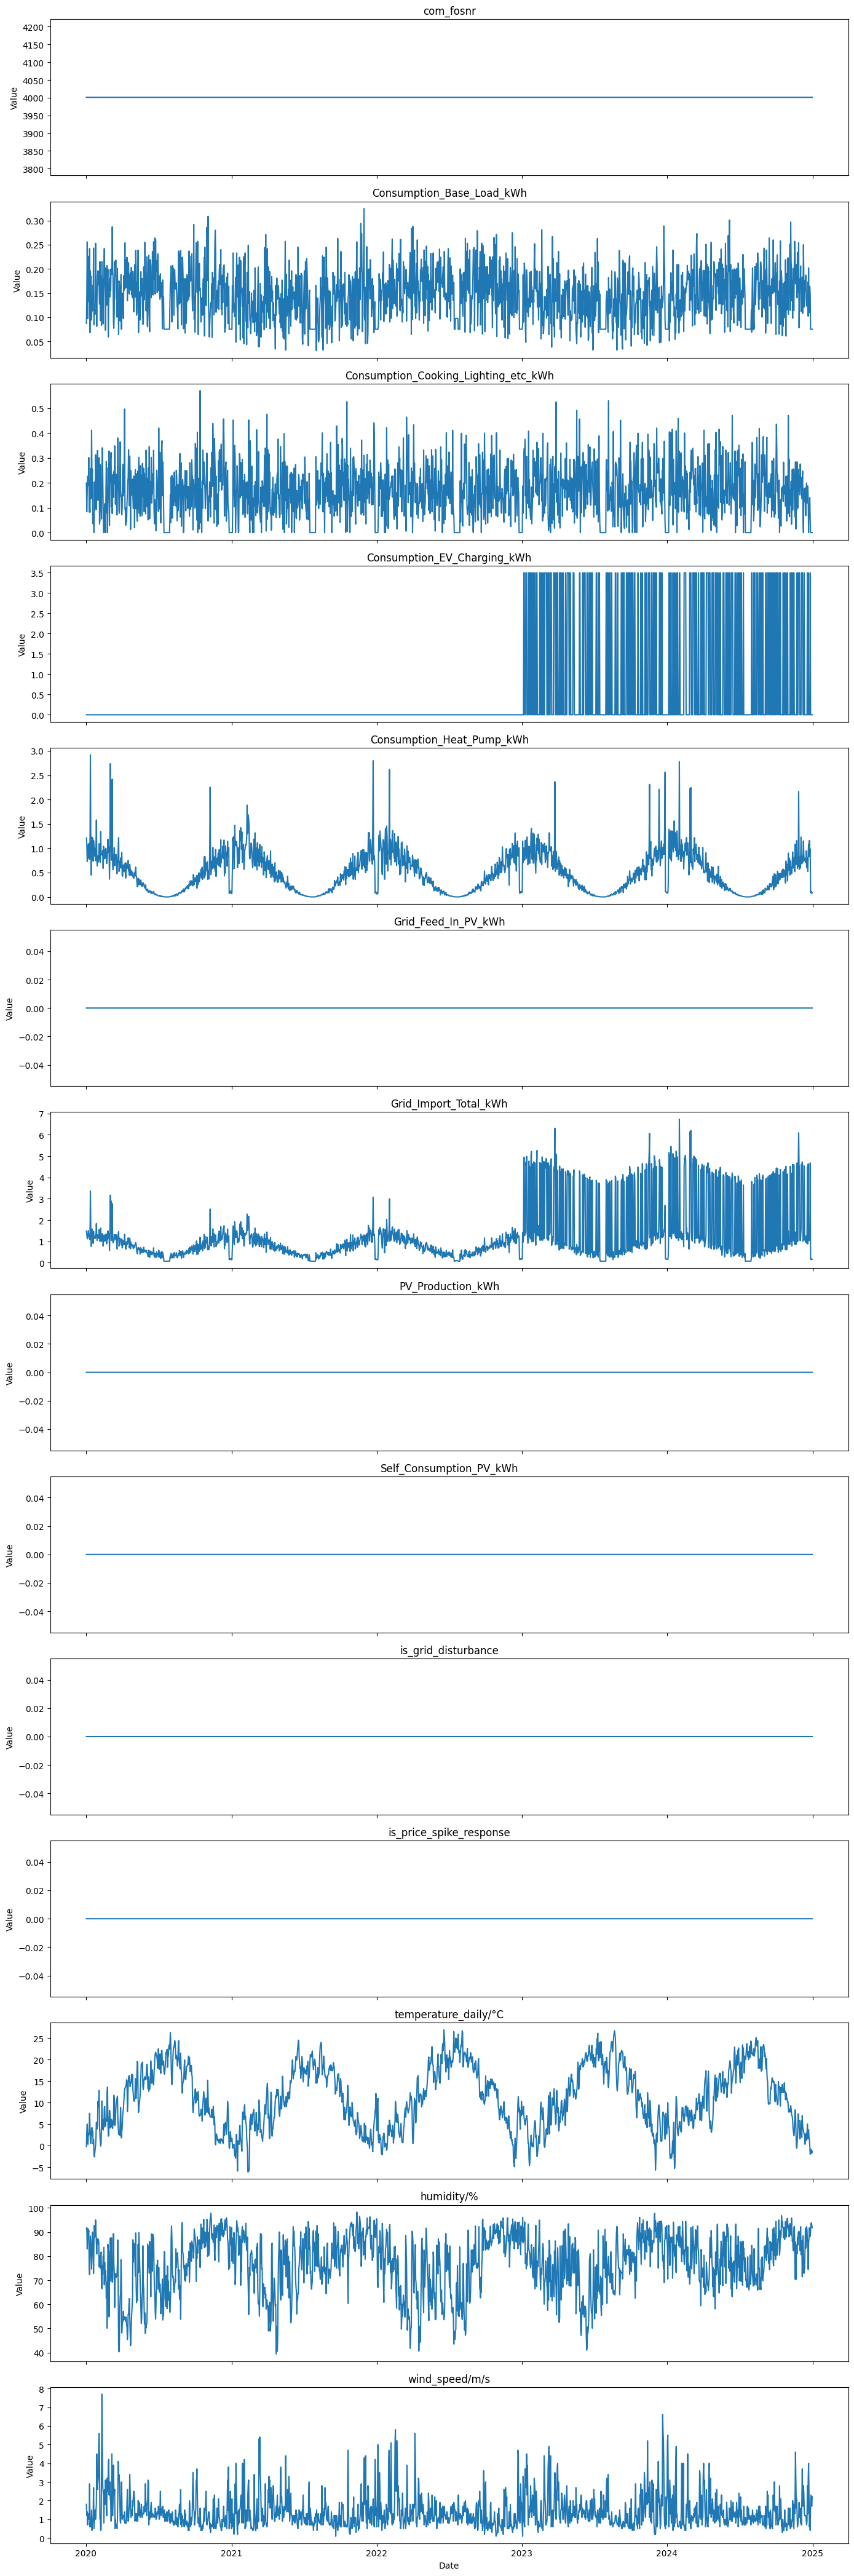

In [79]:
import matplotlib.pyplot as plt

# Ensure Timestamp is datetime
df_merged["Timestamp"] = pd.to_datetime(df_merged["Timestamp"])

# Select numeric columns
numeric_cols = df_merged.select_dtypes(include=["number"]).columns

# Create subplots, one for each parameter
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(14, 3*len(numeric_cols)), sharex=True)

for i, col in enumerate(numeric_cols):
    axes[i].plot(df_merged["Timestamp"], df_merged[col])
    axes[i].set_title(col)   # title is the parameter name
    axes[i].set_ylabel("Value")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

